<a href="https://colab.research.google.com/github/yaaili/test/blob/master/tf2.0/08%E7%8C%AB%E7%8B%97%E8%AF%86%E5%88%AB_%E8%87%AA%E5%AE%9A%E4%B9%89%E8%AE%AD%E7%BB%83_%E6%95%B0%E6%8D%AE%E5%A2%9E%E5%BC%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 导入相关包
from google.colab import drive
drive.mount('/content/gdrive')
import os

os.chdir("/content/gdrive/My Drive/Colab Notebooks/tensorflow")

import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tensorflow version: 2.2.0


# 1. 本文的应用场景是二分类问题，采用的数据集为猫狗分类数据集，训练集图片有2000张，验证集的图片有1000张，分为猫和狗两个类别，图片已经放置在猫狗数据集_2000文件夹下面。

## 2.1 加载图片

In [4]:
#配置数据集路径
path_root = os.path.join(os.path.realpath("."),"DS","dc_2000")
data_dir = pathlib.Path(path_root)

#数量构成
train_image_count = len(list(data_dir.glob('train/*/*.jpg')))
test_image_count = len(list(data_dir.glob('test/*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
print("训练集的数量:{}\n验证集的数量:{}\n数据集类别:{}".format(train_image_count,test_image_count,CLASS_NAMES))

#保存文件的路径,随机打乱
import random  
train_all_image_path = list(data_dir.glob("train/*/*"))
test_all_image_path = list(data_dir.glob("test/*/*"))
train_all_image_path = [str(path) for path in train_all_image_path]
test_all_image_path = [str(path) for path in test_all_image_path]

random.shuffle(train_all_image_path)
random.shuffle(test_all_image_path)

训练集的数量:3032
验证集的数量:1000
数据集类别:['cat' 'dog']


## 2.2 读取图片


{'cat': 0, 'dog': 1}



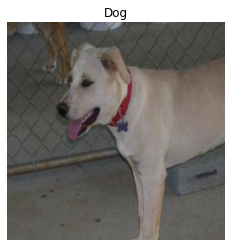

In [25]:
#确定每个图像的标签
lable_names = sorted(item.name for item in data_dir.glob("train/*/"))
#为每个标签分配索引,构建字典
lable_to_index = dict((name,index) for index,name in enumerate(lable_names))
print(lable_to_index)
#创建一个列表，包含每个文件的标签索引
train_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in train_all_image_path]
test_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in test_all_image_path]
#包装为函数，以备后用,图片的预处理
def preprocess_image(image,is_train=True):
    image = tf.image.decode_jpeg(image, channels=3)
    if is_train:
      image = tf.image.resize(image, [360, 360])  #图像剪裁
      image = tf.image.random_crop(image,[256,256,3]) #要写通道
      image = tf.image.random_flip_left_right(image)  #左右翻转
      imgae = tf.image.random_flip_up_down(image)
      #image = tf.image.random_brightness(image,0.5)
      #image = tf.image.random_contrast(image,0,1)
    else:
      image = tf.image.resize(image,[256,256])
    image /= 255.0  # normalize to [0,1] range
    return image
#加载图片
def load_and_preprocess_train_image(path,is_train=True):
    image = tf.io.read_file(path)
    return preprocess_image(image,is_train)
def load_and_preprocess_test_image(path,is_train=False):
    image = tf.io.read_file(path)
    return preprocess_image(image,is_train)


image_path = test_all_image_path[11]
label = test_image_label[11]

plt.imshow(load_and_preprocess_train_image(image_path))
plt.grid(False)
##plt.xlabel(caption_image(image_path))
plt.title(lable_names[label].title())
plt.axis("off")
print()

# 3 图片预处理
在这一部分我们采用from_tensor_slices的方法对图片数据集进行构建，对比tf1.x版本采用队列形式读取数据，这一种方法比较简单切易于理解。
## 3.1 构建（图片，标签）对数据集

In [26]:
#构建一个tf.data.Dataset
#一个图片数据集构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。
#将字符串数组切片，得到一个字符串数据集：
train_path_ds =  tf.data.Dataset.from_tensor_slices(train_all_image_path)
print(train_path_ds)
test_path_ds =  tf.data.Dataset.from_tensor_slices(test_all_image_path)
#现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image来动态加载和格式化图片。
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_image_ds = train_path_ds.map(load_and_preprocess_train_image,num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_test_image,num_parallel_calls=AUTOTUNE)
train_lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_label,tf.int64))
test_lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_label,tf.int64))
for label in train_lable_ds.take(5):
    print(lable_names[label.numpy()])
#%%构建一个（图片，标签）对数据集

#因为这些数据集顺序相同，可以将他们打包起来
image_label_ds = tf.data.Dataset.zip((train_image_ds,train_lable_ds))
test_data = tf.data.Dataset.zip((test_image_ds,test_lable_ds))
print(test_data)

#注意：当你拥有形似 all_image_labels 和 all_image_paths 的数组，tf.data.dataset.Dataset.zip 的替代方法是将这对数组切片
# =================================im============================================
# ds = tf.data.Dataset.from_tensor_slices((all_image_path,all_image_label))
# def load_and_preprocess_from_path_label(path, label):  
#     return load_and_preprocess_image(path),label
# image_label_ds = ds.map(load_and_preprocess_from_path_label)    
# =============================================================================

<TensorSliceDataset shapes: (), types: tf.string>
cat
cat
dog
cat
dog
<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>


# 4. 训练阶段

In [0]:
batch_size = 32
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = image_label_ds.shuffle(buffer_size=train_image_count).batch(batch_size)
test_ds = test_data.batch(batch_size)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
feature,label = next(iter(test_ds))

## 4.1 构建模型

In [36]:
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

#model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

#model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1))

#%%
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 254, 254, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 125, 125, 128)     512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 256)      

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#自定义损失,Sparse是可调用的对象
loss_fuc = tf.keras.losses.BinaryCrossentropy(from_logits=True)# 这是可调用的方法,因为我们没有加入激活函数，所以from_logits=true

#定义损失
def loss(model,x,y):
  y_ = model(x)
  y = tf.expand_dims(tf.cast(y,dtype=tf.float32),axis=1)
  return loss_fuc(y_,y)

#定义平均训练集和测试集平均损失和准确率
train_loss = tf.keras.metrics.Mean("train_loss")
train_accuracy = tf.keras.metrics.Accuracy("train_accuracy") 
test_loss = tf.keras.metrics.Mean("test_loss")
test_accuracy = tf.keras.metrics.Accuracy("test_accuracy") 

#定义train_step
def train_step(model,image,labels):
  with tf.GradientTape() as t:
    pred = model(image)
    loss_step = loss_fuc(tf.expand_dims(tf.cast(labels,dtype=tf.float32),axis=1),pred)
  grads = t.gradient(loss_step,model.trainable_variables)
  optimizer.apply_gradients(zip(grads,model.trainable_variables))
  train_loss(loss_step)
  train_accuracy(labels,tf.cast(pred>0,tf.int64))
#定义train_step
def test_step(model,image,labels):
  pred = model(image)
  loss_step = loss_fuc(tf.expand_dims(tf.cast(labels,dtype=tf.float32),axis=1),pred)
  test_loss(loss_step)
  test_accuracy(labels,tf.cast(pred>0,tf.int64))

def train(model,train_ds,test_ds):
  train_loss_sca = []
  test_loss_sca = []
  train_acc_sca = []
  test_acc_sca = []
  for epoch in range(60):
    for (batch,(image,labels)) in enumerate(train_ds):
      #print(".")
      #进行异步训连
      train_step(model,image,labels)
    for (batch,(image,labels)) in enumerate(test_ds):
      test_step(model,image,labels)
    train_loss_sca.append(train_loss.result())
    test_loss_sca.append(test_loss.result())
    train_acc_sca.append(train_accuracy.result())
    test_acc_sca.append(test_accuracy.result())

    print("epoch{} train_loss is {};train_accuracy is {};test_loss is {};test_accuracy is {}".format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result(),
                               test_loss.result(),
                               test_accuracy.result()
                               ))
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
  return (train_loss_sca,test_loss_sca,train_acc_sca,test_acc_sca)


In [39]:
train_loss_sca,test_loss_sca,train_acc_sca,test_acc_sca = train(model,train_ds,test_ds)

epoch1 train_loss is 0.691035807132721;train_accuracy is 0.5382585525512695;test_loss is 0.6896296739578247;test_accuracy is 0.5199999809265137
epoch2 train_loss is 0.6685991883277893;train_accuracy is 0.5936675667762756;test_loss is 0.6712452173233032;test_accuracy is 0.550000011920929
epoch3 train_loss is 0.6393885016441345;train_accuracy is 0.6411609649658203;test_loss is 0.6313669681549072;test_accuracy is 0.6439999938011169
epoch4 train_loss is 0.6024441719055176;train_accuracy is 0.6721636056900024;test_loss is 0.6539448499679565;test_accuracy is 0.6380000114440918
epoch5 train_loss is 0.5880981683731079;train_accuracy is 0.6959102749824524;test_loss is 0.8423298597335815;test_accuracy is 0.5139999985694885
epoch6 train_loss is 0.5756424069404602;train_accuracy is 0.712730884552002;test_loss is 0.5840185284614563;test_accuracy is 0.6959999799728394
epoch7 train_loss is 0.5359277725219727;train_accuracy is 0.732189953327179;test_loss is 0.533105731010437;test_accuracy is 0.7360000

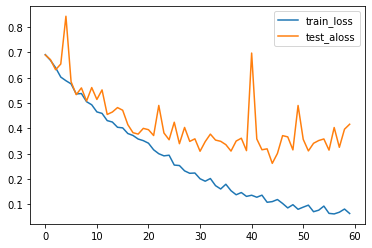

In [42]:
plt.plot([i for i in range(60)], train_loss_sca, label='train_loss')
plt.plot([i for i in range(60)], test_loss_sca, label='test_aloss')
plt.legend()

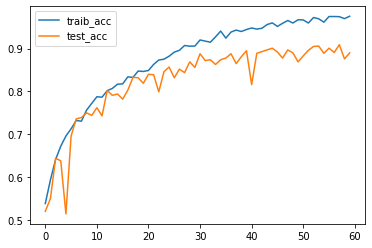

In [43]:
plt.plot([i for i in range(60)], train_acc_sca, label='traib_acc')
plt.plot([i for i in range(60)], test_acc_sca, label='test_acc')
plt.legend()